<a href="https://colab.research.google.com/github/ermersonmoura/GTSRB-Dataset/blob/main/Traffic_Sign_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Modelo de Classificação de sinais de trânsitos**

**Importando bibliotecas e clocando o repositório bold text**

In [473]:
!git clone https://ermersonmoura@bitbucket.org/ia-projects-ermerson/gtsrb-dataset.git
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

fatal: destination path 'gtsrb-dataset' already exists and is not an empty directory.


**Leitura do dataset importado** 

In [474]:
!ls gtsrb-dataset

desktop.ini  README.md	signnames.csv  test.p  train.p	valid.p


**Define a semente para garantir a reproducibilidade do experimento**

In [475]:
np.random.seed(0)

**Carregamento dos dados**

In [476]:
with open('gtsrb-dataset/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('gtsrb-dataset/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Carregamento dos dados de teste
with open('gtsrb-dataset/test.p', 'rb') as f:
    test_data = pickle.load(f)

**Separação dos dados em features (X) e labels (y)**

In [477]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

**Verificar o formato dos arrays**

In [478]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


**Verificação do número de imagens e do formato das imagens (devem ser 32 x 32 x 3)**

In [479]:
assert(X_train.shape[0] == y_train.shape[0]), "O número de imagens não é igual ao número de labels."
assert(X_train.shape[1:] == (32,32,3)), "As dimensões das imagens não são 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "O número de imagens não é igual ao número de labels."
assert(X_val.shape[1:] == (32,32,3)), "As dimensões das imagens não são 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "O número de imagens não é igual ao número de labels."
assert(X_test.shape[1:] == (32,32,3)), "As dimensões das imagens não são 32 x 32 x 3."

**Leitura do arquivo signnames.csv e armazenamento em um DataFrame**

In [480]:
data = pd.read_csv('gtsrb-dataset/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

In [481]:
num_of_samples=[] # uma lista vazia para armazenar o número de amostras por classe
cols = 5 # número de colunas para exibição das imagens
num_classes = 43 # número total de classes no conjunto de dados

**Cria uma figura com subplots para exibir as imagens de casa classe**

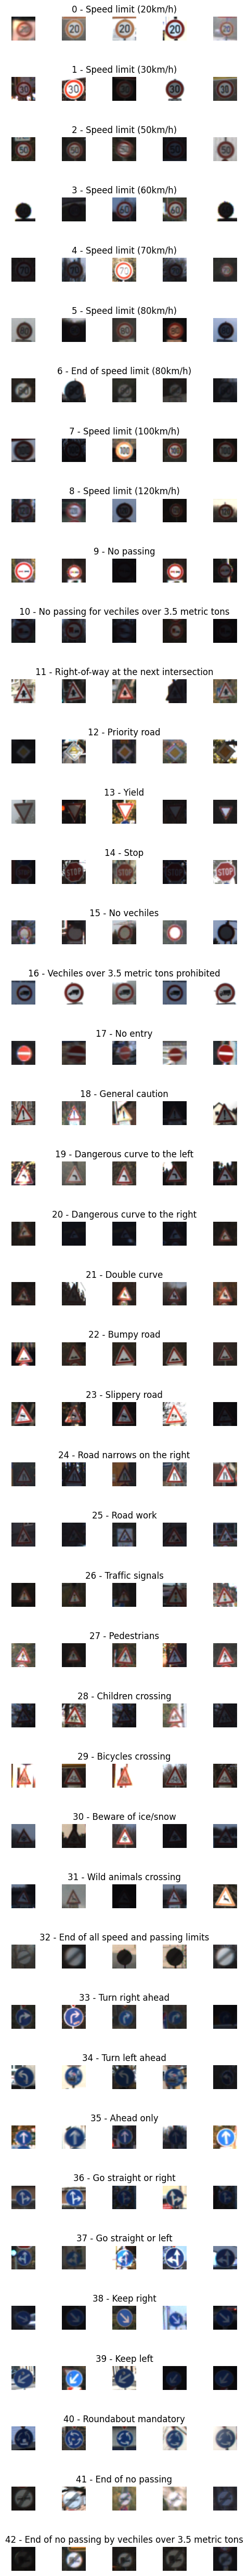

In [482]:
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
      for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

**Exibe o número de amostras por classe**

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


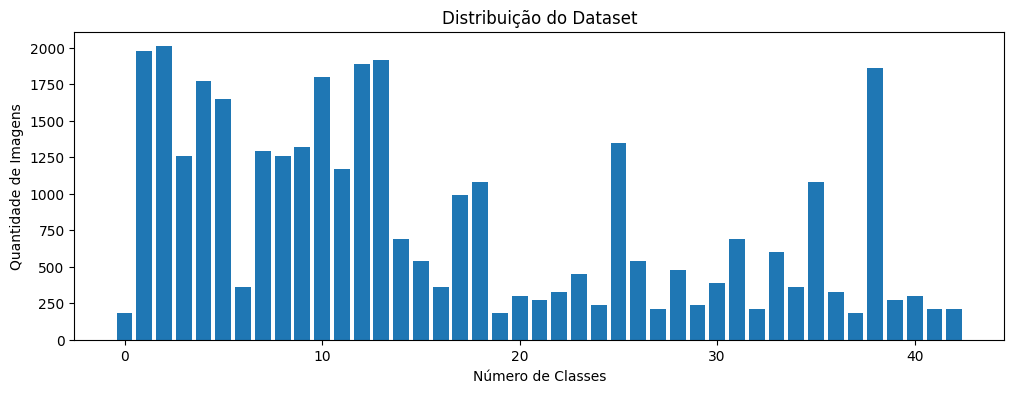

In [483]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribuição do Dataset")
plt.xlabel("Número de Classes")
plt.ylabel("Quantidade de Imagens")
plt.show()

In [484]:
import cv2

**Exibe uma imagem do conjunto de dados**

(32, 32, 3)
36


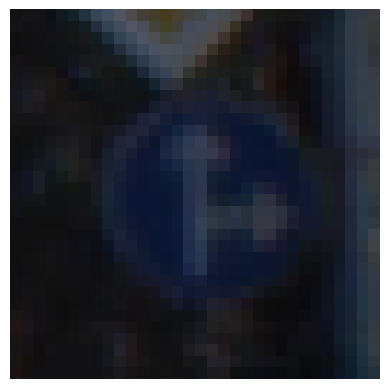

In [485]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

**Função para converter a imagem em escala de cinza**


(32, 32)


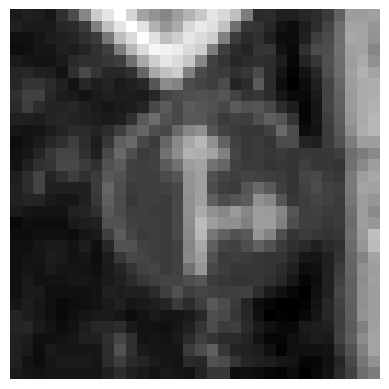

In [486]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
img = grayscale(X_train[1000])
plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

**Função para equalizar o histograma da imagem**

(32, 32)


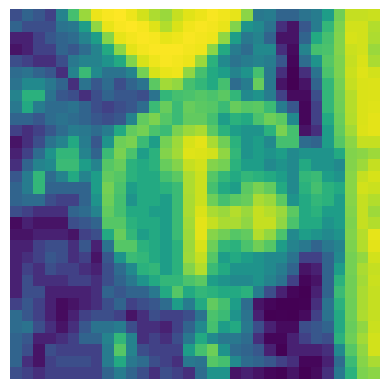

In [487]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

**Função para pré-processar a imagem antes de alimentar na rede neural**

In [488]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

**Exibe uma imagem pré-processada aleatória**

(34799, 32, 32)


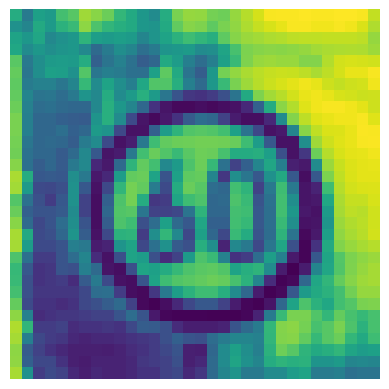

In [489]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

**Remodela os conjuntos de dados**

In [490]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

**Cria o Data Augmentation do modelo**

In [491]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)

**Gera as imagens do Data Augmentation e visualização dos dados gerados**

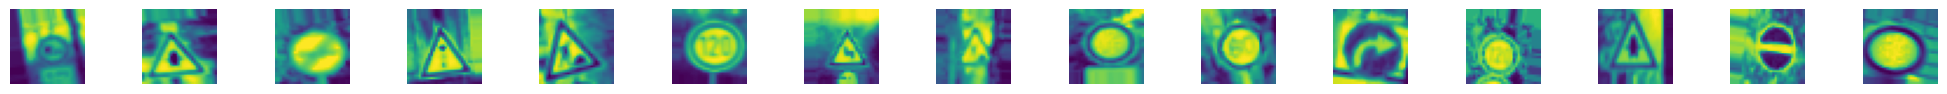

In [492]:
batches = datagen.flow(X_train, y_train, batch_size=30)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [493]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


**Transformação dos dados de treinamento, teste e validação para o formato one-hot**

In [494]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

**Definição da rede neural (modelo)**

In [495]:
def model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


**Instanciação do modelo e impressão da estrutura da rede**

In [496]:
model = model()
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         (None, 28, 28, 60)        1560      
                                                                 
 conv2d_136 (Conv2D)         (None, 24, 24, 60)        90060     
                                                                 
 conv2d_137 (Conv2D)         (None, 20, 20, 60)        90060     
                                                                 
 conv2d_138 (Conv2D)         (None, 16, 16, 60)        90060     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 8, 8, 60)         0         
 g2D)                                                            
                                                                 
 conv2d_139 (Conv2D)         (None, 6, 6, 30)          16230     
                                                     

**Treinamento do modelo com dados gerados por datagen**

In [497]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=20), steps_per_epoch=1737, epochs=30, validation_data=(X_val, y_val), shuffle = 1)



Epoch 1/30
1737/1737 [==============================] - 23s 13ms/step - loss: 2.8393 - accuracy: 0.2229 - val_loss: 1.4690 - val_accuracy: 0.5370
Epoch 2/30
1737/1737 [==============================] - 21s 12ms/step - loss: 1.4932 - accuracy: 0.5410 - val_loss: 0.6241 - val_accuracy: 0.7857
Epoch 3/30
1737/1737 [==============================] - 21s 12ms/step - loss: 1.0140 - accuracy: 0.6830 - val_loss: 0.4216 - val_accuracy: 0.8599
Epoch 4/30
1737/1737 [==============================] - 21s 12ms/step - loss: 0.7435 - accuracy: 0.7656 - val_loss: 0.2382 - val_accuracy: 0.9268
Epoch 5/30
1737/1737 [==============================] - 21s 12ms/step - loss: 0.5753 - accuracy: 0.8218 - val_loss: 0.1984 - val_accuracy: 0.9299
Epoch 6/30
1737/1737 [==============================] - 20s 12ms/step - loss: 0.4639 - accuracy: 0.8555 - val_loss: 0.1399 - val_accuracy: 0.9551
Epoch 7/30
1737/1737 [==============================] - 21s 12ms/step - loss: 0.3728 - accuracy: 0.8843 - val_loss: 0.1340 -

**Visualização dos resultados de treinamento**

Text(0.5, 0, 'epoch')

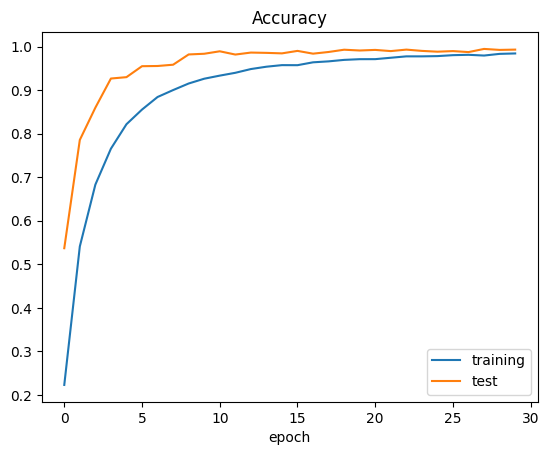

In [498]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

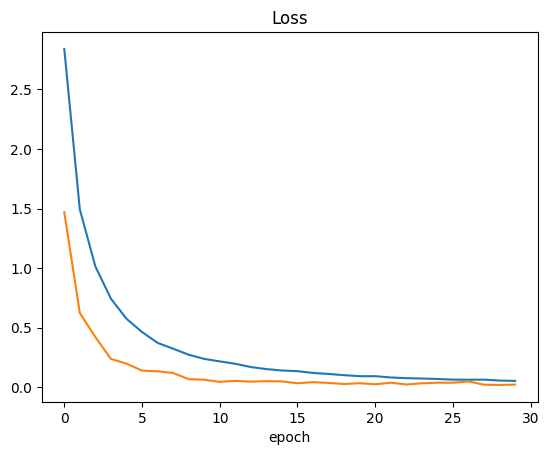

In [499]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

**Avaliação do modelo com dados de teste**

In [500]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.13625212013721466
Test accuracy: 0.9738717079162598


**Importação de imagem da internet, preprocessamento e teste da eficiência do modelo**

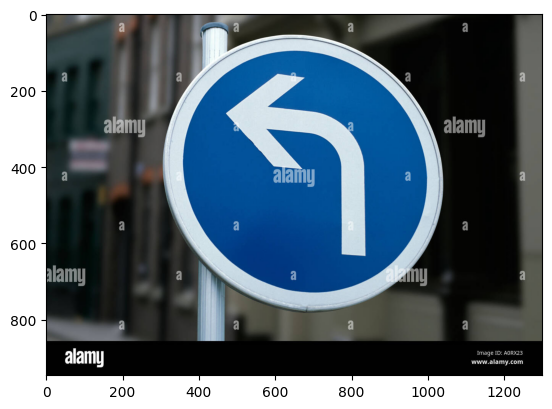

In [516]:
#UTILIZE QUALQUER IMAGEM DE SINAIS DE TRÂNSITO NA WEB PARA TESTAR A EFICIÊNCIA DO MODELO. 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


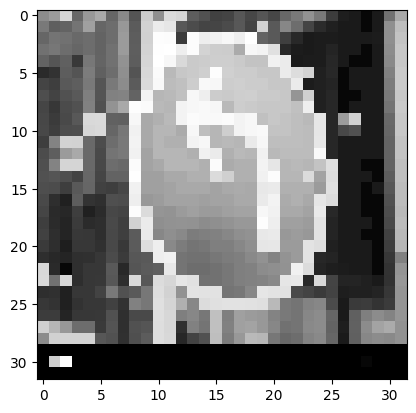

In [517]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)


**Redimensiona o array da imagem para uma forma compatível com o modelo de aprendizado de máquina utilizado**

In [518]:
img = img.reshape(1, 32, 32, 1)

**Utiliza o modelo de aprendizado de máquina para prever qual é o sinal de trânsito representado na imagem**

In [519]:
pred = np.argmax(model.predict(img), axis =-1)
print("Predicted sign: " + str(pred))

1/1 [==============================] - 0s 20ms/step
Predicted sign: [34]
